This notebook consists of code for reading in the .tiff whole slide image files. It makes use of the openslide library and uses parts of the notebook from the [MIDOG challenge data exploration notebook](https://imig.science/midog/download-dataset/).

The output from this notebook will be a folder structure that can be used with pytorch to create an object detection model.

### Imports

We need to import openslide, PIL, Pandas and other important libraries to load the annotations and process the data to a form we can use.

In [15]:
%%capture
import pandas as pd
import json
from PIL import Image as im
import PIL.ImageDraw as ImageDraw
from tqdm import tqdm

Openslide is originally a C library for interfacing with whole slide images. The openslide-python interface makes use of this library to allow the functionality to be used in Python. The Openslide C library needs to be downloaded and added to the dll directory to be used with openslide-python. These dlls can be found [here](https://openslide.org/download/#windows-binaries)

In [2]:
# The path can also be read from a config file, etc.
OPENSLIDE_PATH = r'D:\DS\DS4\Project\openslide-win64\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

from openslide import open_slide

### Reading in the data

From the MIDOG page we can get the IDs for each tissue type. The last set does not contain any labels for use, so these will not be included.

In [3]:
midog_folder = Path("E:/MIDOG_Challenge_2022")
image_folder = midog_folder / "images"

midog_ids = list(range(1, 151))
clc_ids = list(range(151,195))
cly_ids = list(range(195,250))
ccmct_ids = list(range(250,300))
net_ids = list(range(300,355))
mel_ids = list(range(355,406))

all_ids = {'human breast cancer': midog_ids,
           'canine lung cancer': clc_ids,
           'canine lymphoma' : cly_ids,
           'canine cutaneous mast cell tumor' : ccmct_ids,
           'human neuroendocrine tumor' : net_ids,
           'human melanoma' : mel_ids}

id_to_tumortype = {id:list(k for k in all_ids if id in all_ids[k])[0] for id in range(1,406)}

After reading in the training.json we can extract information about the individual annotatiosn and use this to create a table as an easy way of managing all of this metadata for annotations.

In [4]:
annotation_file = midog_folder / "MIDOG2022_training.json"
rows = []
with open(annotation_file) as f:
    data = json.load(f)

    categories = {1: 'mitotic figure', 2: 'hard negative'}

    for row in data["images"]:
        file_name = row["file_name"]
        image_id = row["id"]
        width = row["width"]
        height = row["height"]

        tumortype = id_to_tumortype[image_id]
         
        for annotation in [anno for anno in data['annotations'] if anno["image_id"] == image_id]:
            box = annotation["bbox"]
            cat = categories[annotation["category_id"]]


            rows.append([file_name, image_id, width, height, box, cat, tumortype])

df = pd.DataFrame(rows, columns=["file_name", "image_id", "width", "height", "box", "cat", "tumortype"])

### Inspecting the annotations

We can look at one particular slide and visualise some of the annotatations present. To do this we can filter our table to look at only the annotations in a single slide, for example "002.tiff"

In [5]:
current_file = df[df["file_name"] == "002.tiff"]

In [6]:
current_file

,file_name,image_id,width,height,box,cat,tumortype
4,002.tiff,2,7215,5412,"[1872, 319, 1922, 369]",hard negative,human breast cancer
5,002.tiff,2,7215,5412,"[4397, 191, 4447, 241]",mitotic figure,human breast cancer
6,002.tiff,2,7215,5412,"[1842, 1558, 1892, 1608]",mitotic figure,human breast cancer
7,002.tiff,2,7215,5412,"[3783, 2346, 3833, 2396]",hard negative,human breast cancer
8,002.tiff,2,7215,5412,"[5319, 3252, 5369, 3302]",mitotic figure,human breast cancer
9,002.tiff,2,7215,5412,"[6242, 3193, 6292, 3243]",mitotic figure,human breast cancer
10,002.tiff,2,7215,5412,"[7045, 3791, 7095, 3841]",hard negative,human breast cancer
11,002.tiff,2,7215,5412,"[4450, 4059, 4500, 4109]",hard negative,human breast cancer
12,002.tiff,2,7215,5412,"[4636, 4294, 4686, 4344]",mitotic figure,human breast cancer
13,002.tiff,2,7215,5412,"[1306, 4912, 1356, 4962]",mitotic figure,human breast cancer


To look at these annotations we need to determine which part of the slide they reside on. This is because it is memory intensive to load the whole slide at one time.

Typically, it is good practice to break the slide into tiles of equal size, so we will look at 512x512 tiles. This means we need to find the tile an annotation lies in, and then scale the annotations co-ordinates so we can display the annotation as normal on that tile.

There is one issue with taking a tiling appraoch. There is a chance that annotations will lie on the boundary between 2 or possibly 4 tiles. This means that it will be cut off and not included in our data. One possible solution to this is to include overlap between tiles. This is a very simple approach that will essentially allow for the data to be captured, but at the cost of it being duplicated across different tiles. We will only take the annotation to exist in the first tile that captures it as we are not too concerned with this.

We can see that we have extracted a tile and the annotation can be located on this tile.

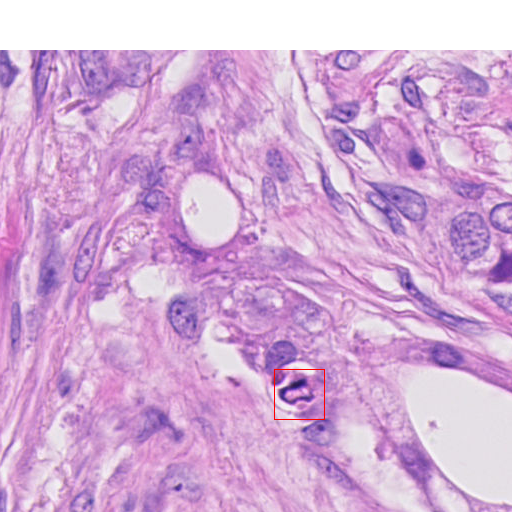

In [7]:
file_path = image_folder / "002.tiff"
slide = open_slide(str(file_path))
imgs = []
for id, anno in current_file.iterrows():

    left, bottom, right, top = [divmod(int(v), 412) for v in anno.box]

    if left[0] != right[0]:
        smallest = min(left[0], right[0])

        if left[0] == smallest:
            right = (smallest, right[1] + 412)
  
    if top[0] != bottom[0]:
        smallest = min(top[0], bottom[0])

        if bottom[0] == smallest:
            top = (smallest, top[1] + 412)
  
    img = slide.read_region(((left[0] * 412) - 50, (top[0] * 412) - 50), level=0, size=(512, 512))

    left = (left[0], left[1] + 50)
    bottom = (bottom[0], bottom[1] + 50)
    right = (right[0], right[1] + 50)
    top = (top[0], top[1] + 50)

    d = ImageDraw.Draw(img)
    d.rectangle([left[1], bottom[1], right[1], top[1]], outline="red")
    display(img)
    break


### Generating the data for training

We will make use of our table from before and create a PNG image for each tile and assign annotations to this training image. Once both of these are saved we will have captured all of our data in a useable format.

As previously mentioned, we will be taking a tiling approach to reduce the memory load. To avoid annotations being split between tiles we will introduce some overlap. Each tile will be 412 pixels x 412 pixels of with a 50 pixel padding that will overlap with the adjoining tiles. This means that the centre 312 x 312 of a tile will be unique, the next 50 pixel ring will be displayed in adjoining tiles and the last 50 pixel ring will be this tile taking some of the adoining tiles. 

This motivates the selection of a 50 pixel overlap between tiles as oppossed to a smaller overlap. As each annotation is at most 50 pixels, it can never be split between these overlapping tiles. With a smaller overlap this would no longer be the case and annotations could still be split, although very unlikely. We can choose to repeat an annotation as long as the complete bounding box exists within the image.

In [18]:
# Now we will make use of some utility functions to carry out the task of generating the tiles and 
# cataloguing the metadata

from math import ceil

def get_tile_number(pixel_length, tile_size=412):
    """
    This function finds the number of tiles along the x or y axis from the length of pixels and tile size.
    """
    return ceil(pixel_length / tile_size)

def get_tile_id(x_tile, y_tile, x_tile_max):
    """
    This function calculates the tile id which is the position of a tile in the grid when traversing
    rows first and then moving down a column
    """
    return (y_tile * x_tile_max) + x_tile

def shift_coord(coord, shidt_amount=50):
    """
    Shift a given co-ordinate by a given value
    """
    return (coord[0], coord[1] + 50)

def process_annotation(bbox):
    """
    This function takes the bounding box and scales the co-ordinates to the tile they reside upon and 
    also gives back the tile ids.
    """
    left, bottom, right, top = [divmod(int(v), 412) for v in bbox]

    # If the left and right value along the x-axis are on different unique tiles, we ensure they're on the same one and shift
    # the co-ordinates of the right-most value.
    if left[0] != right[0]:
        smallest = min(left[0], right[0])

        if smallest < 0:
            left = (0, left[1])

        elif left[0] == smallest:
            right = (smallest, right[1] + 412)

    # The same as with the x-axis but this time looking at the difference between the top and bottom co-ordinates.
    if top[0] != bottom[0]:
        smallest = min(top[0], bottom[0])

        if smallest < 0:
            bottom = (0, bottom[1])

        elif bottom[0] == smallest:
            top = (smallest, top[1] + 412)

    # Shift the co-ordinates to account for the overlap we add to the tile
    left = shift_coord(left)
    bottom = shift_coord(bottom)
    right = shift_coord(right)
    top = shift_coord(top)

    return [left, bottom, right, top]


def determine_tiles(bboxes, height, width):
    """
    This function create a dictionary with the tiles_ids that contain annotations as the keys and the bounding
    boxes of these tiles as elements in a list.
    """
    tiles_dict = {}

    # Get the number of tiles in a row and column for the given slide, this is based on the height and width of the image.
    x_tiles, y_tiles = get_tile_number(width), get_tile_number(height)
  
    for bbox in bboxes:
        # Process the annotation, this involves shifting the co-ordinates to sit on the new tile.
        left, bottom, right, top = process_annotation(bbox)

        # calculate the tile id for this annotation
        tile_id = get_tile_id(left[0], bottom[0], x_tiles)

        # If we have yet to add this tile to the dictionary for tiles with annotations add it with an empty list as the value
        if tile_id not in tiles_dict.keys():
            tiles_dict[tile_id] = []

        # Append the bounding box to the list for the tile_id that it occurs on.
        tiles_dict[tile_id].append([left, bottom, right, top])

    return tiles_dict

def extract_tiles(slide, tiles_dict, image_id, output_path):
    """
    This function extracts the necessary tiles from a slide, this is determined from the dictionary of tiles
    with their corresponding annotations. It also creates a dictionary with metadata for tiles. This innclues
    the tile ids, their annotations and the classes of these annotations.
    """
    # List for capturing the metadata of each tile.
    tile_list = []

    # loop through the tiles
    for tile_id, bboxes in tiles_dict.items():

        # Create a dictionmary for the metadata for this tile.
        current_tile = {"tile_id": int(tile_id), "annotations": []}
        
        # Use the information on the tile for this annotation to extract only the necessary data.
        # Using multiples of 412 will cycle through the unique data and then move back 50 pixels in both 
        # the x and y direction to capture the data for the overlap.
        img = slide.read_region(((left[0] * 412) - 50, (top[0] * 412) - 50), level=0, size=(512, 512))
        img.save(output_path / "data" / f"{image_id:03d}_{tile_id:03d}.png", "PNG")

        # Loop through the bounding boxes
        for bbox in bboxes:
            left, bottom, right, top = bbox

            # Add the information from this annotation to the tile metadata.
            current_tile["annotations"].append({"class_name": "mitotic_figure", "bounding_box": {"left": int(left[1]), "bottom": int(bottom[1]), "right": right[1], "top": int(top[1])}})

        # Add the tile metadata to the list
        tile_list.append(current_tile)

    return tile_list


In [19]:
# We need to create an output dictionary, filter down the data and specify the output path.
output_dict = {"images": []}
mitotic_figure_df = df[df["cat"] == "mitotic figure"]
output_path = Path("E:/Training_mitotic_figures")

all_ids = {'human breast cancer': midog_ids,
           'canine lung cancer': clc_ids,
           'canine lymphoma' : cly_ids,
           'canine cutaneous mast cell tumor' : ccmct_ids,
           'human neuroendocrine tumor' : net_ids,
           'human melanoma' : mel_ids}

# Loop through the id types, breast cancer, canine lymphoma, etc.
for id_type, id_values in all_ids.items():

  # Loop through the image ids
  for image_id in tqdm(id_values, desc=f"Slides processed of type {id_type}"):
    
    # Filter the df of annotations to only have the ones from this current slide.
    current_image_df = mitotic_figure_df[mitotic_figure_df["image_id"] == image_id]

    # If this slide doesn't have any mitotic figures we can move to the next slide
    if current_image_df.empty:
        continue

    # Get all of the bounding boxes on the tile
    bboxes = current_image_df["box"]

    # determine what tiles we need
    image_height, image_width = current_image_df["height"].unique()[0], current_image_df["width"].unique()[0]
    tiles_dict = determine_tiles(bboxes, image_height, image_width)

    try:
        # Open the current slide
        filename = current_image_df["file_name"].unique()[0]
        file_path = image_folder / filename

        with open_slide(str(file_path)) as slide:

            # extract the tiles and save them to MyDrive
            tile_info = extract_tiles(slide, tiles_dict, image_id, output_path)

            # Create the metadata for the current image and append it to the total metadata
            current_image = {"image_id": int(image_id), "tiles": tile_info, "image_height": int(image_height), "image_width": int(image_width), "tumour_type": id_type, "original_filename": filename}
            output_dict["images"].append(current_image)

    except Exception as e:
        print(e)

# Once the data processing is done, save the json file with the metadata regarding bounding boxes
with open(output_path / "training.json", "w") as f:
    json.dump(output_dict, f)


Slides processed of type canine lymphoma: 100%|████████████████████████████████████████| 55/55 [30:50<00:00, 33.64s/it]
Slides processed of type canine cutaneous mast cell tumor: 100%|███████████████████████| 50/50 [17:22<00:00, 20.84s/it]
Slides processed of type human neuroendocrine tumor: 100%|█████████████████████████████| 55/55 [06:06<00:00,  6.66s/it]
Slides processed of type human melanoma: 100%|███████████████████████████████████████| 51/51 [00:00<00:00, 4250.14it/s]


### Test our data

Now that we have processed the data into the form we can use for training, let us ensure that we have made no errors in our processing. To do this we will look at several images randomly and ensure that the annotations seem reasonable.

The code below will generate 5 random tiles with all of their annotations displayed.

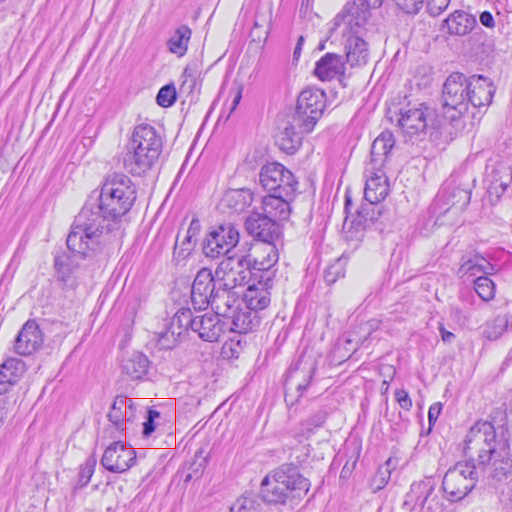

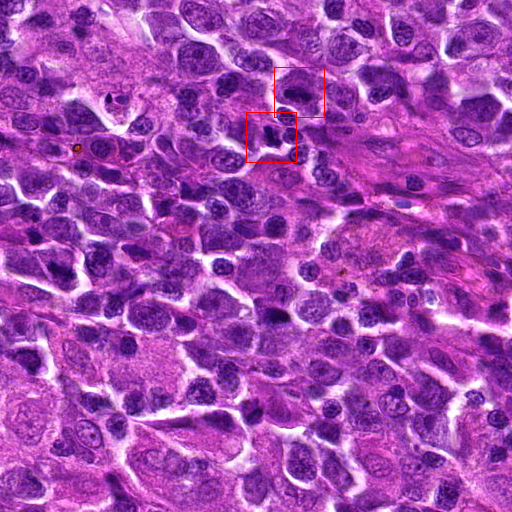

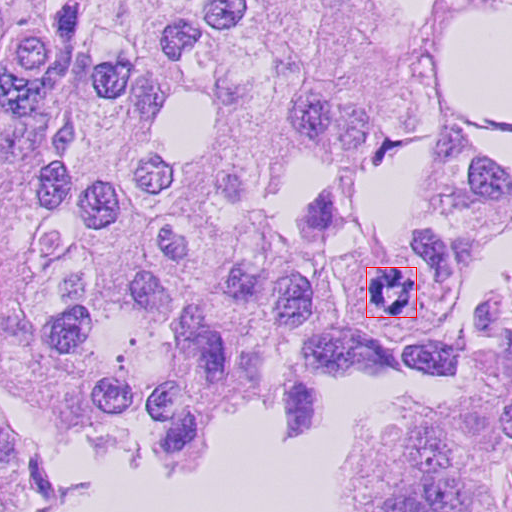

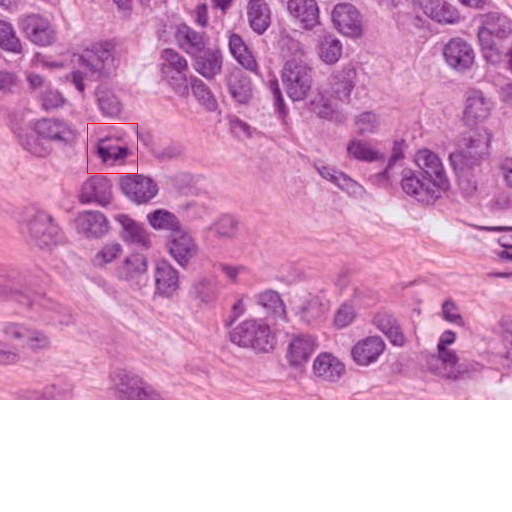

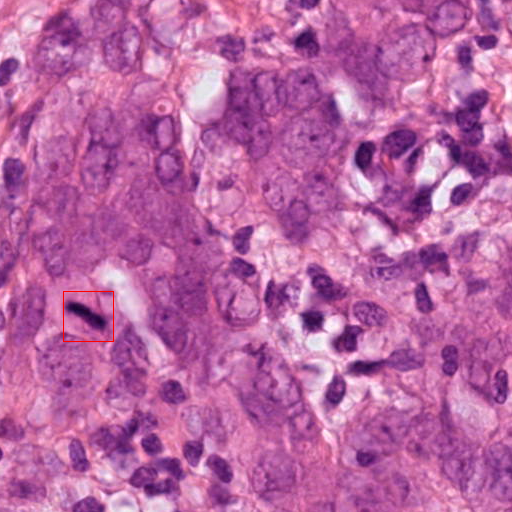

In [24]:
import random

image_folder = Path("E:/Training_mitotic_figures/data")
with open(output_path / "training.json") as t:
    training_data = json.load(t)

for i in range(5):
    img = random.choice(training_data["images"])
    tile = random.choice(img["tiles"])
  

    image_id = img["image_id"]
    tile_id = tile["tile_id"]

    filename = f"{image_id:03d}_{tile_id:03d}.png"
    file_path = image_folder / filename
    with im.open(str(file_path)) as img:

        d = ImageDraw.Draw(img)

        for anno in tile["annotations"]:

            left, bottom, right, top = anno["bounding_box"].values()
            d.rectangle([left, bottom, right, top], outline="red")
            
        display(img)
        
    


### Training dataset overview

Now we will quickly sanity check the data, ensuring that all annotations are accounted for. We will also look at how many annotations, tiles and slides we have of each type, the data reduction for each and the average annotations per tile.

In [52]:
def count_annotations(output_dict):
    count = 0
    for image in output_dict["images"]:
        for tile in image["tiles"]:
            count += len(tile["annotations"])
    return count

def zero_division_catch(numerator, denominator):
    try:
        return numerator / denominator
    except ZeroDivisionError as r:
        return 0

In [66]:
type_dict = {}

original_annotations = len(mitotic_figure_df)
new_annotations = count_annotations(output_dict)

print(f"Old annotation count: {original_annotations}")
print(f"New annotation count: {new_annotations}")
print(f"Count is the same? {original_annotations == new_annotations}")
print("--------------------------\n")

for id_type, id_values in all_ids.items():
    
    slides, tiles, all_tiles, annos = 0, 0, 0, 0 
    
    # See which slides have annotations on them
    slides_with_annotations[id_type] = [id_value for id_value in id_values if id_value in mitotic_figure_df["image_id"].unique()]
    
    for id_value in id_values:
    
        image_dict = next((image for image in output_dict["images"] if image["image_id"] == id_value), None)
        
        if image_dict is None:
            continue
        
        slides += 1
        
        # Find the total tiles
        all_tiles += get_tile_number(image_dict["image_height"]) * get_tile_number(image_dict["image_width"])
    
        # check each annotation has been counted. Get allo annotations for a slide and remove one each time we encounter one.
        # When we have accounted for all the annotations we should have 0 left in the dict.
        
        for tile in image_dict["tiles"]:
            tiles += 1
            annos += len(tile["annotations"])
    
    type_dict[id_type] = {"slide_count": slides, "tile_count": tiles, "annotation_count": annos, "all_tiles": all_tiles}

# Print the counts
# Get percentage of original data that still remains, type and total
# Average annotations per tile, type and total
total_slide_count, total_tile_count, total_annotation_count, total_all_tiles = 0, 0, 0, 0
for k, v in type_dict.items():
    
    slide_count, tile_count, annotation_count, total_tiles = v["slide_count"], v["tile_count"], v["annotation_count"], v["all_tiles"]

    print(f"{k}")
    print("--------------------")
    print(f"Slide count: {slide_count} Tile count: {tile_count} Annotation count: {annotation_count}")
    

    reduction = zero_division_catch((total_tiles - tile_count), total_tiles)
    print(f"Reduction of slide data while maintaining all annotations: {reduction:.2f}%")
    
    annos_per_tile = zero_division_catch(annotation_count, tile_count)
    print(f"Average annotations per tile: {annos_per_tile:.2f}")
    
    total_slide_count += slide_count
    total_tile_count += tile_count
    total_annotation_count += annotation_count
    total_all_tiles += total_tiles
    print()

print(f"Total")
print("--------------------")
print(f"Slide count:{total_slide_count} Tile count: {total_tile_count} Annotation count: {total_annotation_count}")
    
reduction = zero_division_catch((total_all_tiles - total_tile_count), total_all_tiles)
print(f"Reduction of slide data while maintaining all annotations: {reduction:.2f}")

annos_per_tile = zero_division_catch(total_annotation_count, total_tile_count)
print(f"Average annotations per tile: {annos_per_tile:.2f}")



Old annotation count: 9501
New annotation count: 9501
Count is the same? True
--------------------------

human breast cancer
--------------------
Slide count: 135 Tile count: 1580 Annotation count: 1721
Reduction of slide data while maintaining all annotations: 0.95%
Average annotations per tile: 1.09

canine lung cancer
--------------------
Slide count: 44 Tile count: 776 Annotation count: 855
Reduction of slide data while maintaining all annotations: 0.91%
Average annotations per tile: 1.10

canine lymphoma
--------------------
Slide count: 55 Tile count: 2975 Annotation count: 3959
Reduction of slide data while maintaining all annotations: 0.72%
Average annotations per tile: 1.33

canine cutaneous mast cell tumor
--------------------
Slide count: 50 Tile count: 1654 Annotation count: 2327
Reduction of slide data while maintaining all annotations: 0.83%
Average annotations per tile: 1.41

human neuroendocrine tumor
--------------------
Slide count: 48 Tile count: 564 Annotation coun

### Conclusion

We can see that we have not lost any mitotic figure annotations during our processing. We have also reduced our data by ~90% overall, while maintaining all of the annotations and contextual information around them that is captured by a tile. This is a lower figure than the actual data saved as we are rounding up to complete tiles, though tiles may not perfectly fit an image and may contain only partial data at the slide edges.

It can be seen that a large portion of our annotations come from canine tissue.